<a href="https://colab.research.google.com/github/marendtz/News_NER/blob/master/XLMR_pan_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Preparations**

In [ ]:
# for debugging: clean up model
import shutil
try:
  shutil.rmtree('/content/xlm-roberta-base-finetuned-panx-en')
except:
  print("no such folder")

no such folder


In [ ]:
# get github access token for collab
import getpass
token = getpass.getpass()

··········


In [ ]:
# clean workdir
%cd /content/
%rm -r /content/*
%ls -la
%pwd

/content
total 16
drwxr-xr-x 1 root root 4096 Apr 30 08:01 ./
drwxr-xr-x 1 root root 4096 Apr 30 07:56 ../
drwxr-xr-x 4 root root 4096 Apr 27 13:34 .config/


'/content'

In [ ]:
# clone github repo
!git clone https://{token}@github.com/marendtz/News_NER.git

Cloning into 'News_NER'...
remote: Enumerating objects: 18, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 18 (delta 6), reused 9 (delta 1), pack-reused 0
Unpacking objects: 100% (18/18), 139.20 KiB | 2.96 MiB/s, done.


In [ ]:
# install dependencies
%pip install -r /content/News_NER/requirements.txt

In [24]:
# import packages
from collections import defaultdict
import pandas as pd
import numpy as np
from datasets import load_dataset_builder, get_dataset_config_names, load_dataset, DatasetDict

from transformers import AutoTokenizer, TrainingArguments, DataCollatorForTokenClassification, Trainer, AutoModelForTokenClassification
import nltk.data
nltk.download('punkt')

import torch.nn as nn
from transformers import XLMRobertaConfig, AutoConfig, XLMRobertaForTokenClassification
from transformers.modeling_outputs import TokenClassifierOutput

from huggingface_hub import notebook_login
from seqeval.metrics import f1_score, precision_score, recall_score, accuracy_score, classification_report
from seqeval.scheme import IOB2


from torch.nn.functional import cross_entropy
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


**Get and Analyze dataset from Huggingface**

In [21]:
# define model

# get info from dataset later used for training our model
# load dataset to get the tags used, so we later take the same...
lang = "en"
ds = load_dataset("xtreme", name=f"PAN-X.{lang}")
tags = ds["train"].features["ner_tags"].feature
print(tags)

# generate function to convert name and id of tags
index2tag = {idx: tag for idx, tag in enumerate(tags.names)}
tag2index = {tag: idx for idx, tag in enumerate(tags.names)}
print(index2tag)
print(tag2index)

  0%|          | 0/3 [00:00<?, ?it/s]

ClassLabel(names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC'], id=None)
{0: 'O', 1: 'B-PER', 2: 'I-PER', 3: 'B-ORG', 4: 'I-ORG', 5: 'B-LOC', 6: 'I-LOC'}
{'O': 0, 'B-PER': 1, 'I-PER': 2, 'B-ORG': 3, 'I-ORG': 4, 'B-LOC': 5, 'I-LOC': 6}


**Prepare PAN-X test data**

In [22]:
# prepare dataset
panx_ch = defaultdict(DatasetDict)

langs = ["en"] # e.g. ["de","en"]
fracs = [1.0] # e.g. [0.5,0.5]
# panx_ch contains keys for each language and one level lower keys for all splits - here only eng and all data is selected
for lang, frac in zip(langs, fracs):
    # Load monolingual corpus
    ds = load_dataset("xtreme", name=f"PAN-X.{lang}")
    # Shuffle and downsample each split according to spoken proportion
    for split in ds:
        panx_ch[lang][split] = (
            ds[split]
            .shuffle(seed=0)
            .select(range(int(frac * ds[split].num_rows))))
print(panx_ch)
print("Example element in Pan-X Dataset:")
panx_ch_element = panx_ch["en"]["test"][123]
for key, value in panx_ch_element.items():
    print(f"{key}: {value}")

  0%|          | 0/3 [00:00<?, ?it/s]

defaultdict(<class 'datasets.dataset_dict.DatasetDict'>, {'en': DatasetDict({
    train: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 20000
    })
    validation: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 10000
    })
    test: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 10000
    })
})})
Example element in Pan-X Dataset:
tokens: ["'", "''", 'Dobruška', "''", "'", '-']
ner_tags: [0, 0, 5, 0, 0, 0]
langs: ['en', 'en', 'en', 'en', 'en', 'en']


**Prepara Custom Test Data**

In [54]:
ds_custom = load_dataset("maren-hugg/news_ner_dict")

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/2 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1 [00:00<?, ? examples/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/maren-hugg___parquet/maren-hugg--news_ner_dict-912bfa5b6de7e043/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

**Set tokenizer and model**

In [31]:
# setup for tokenization
xlmr_model_name = "maren-hugg/xlm-roberta-base-finetuned-panx-en"
xlmr_tokenizer = AutoTokenizer.from_pretrained(xlmr_model_name)
xlmr_model = AutoModelForTokenClassification.from_pretrained(xlmr_model_name)

**Define helper function for data preparation**

In [56]:
# the library datasets provides a fast way to tokenize dataset objects with the map() operation.
# the returned input ids need to be augmented with the attention mask and the label ids, that encode the information about with token is associated with each NER tag

def tokenize_and_align_labels(examples):
  tokenized_inputs = xlmr_tokenizer(examples["tokens"], truncation=True, is_split_into_words=True)  # sequence is already split in words
  labels = []
  for idx, label in enumerate(examples["ner_tags"]):
    word_ids = tokenized_inputs.word_ids(batch_index=idx) # get word ids to associate subwords
    previous_word_idx = None
    label_ids = []
    for word_idx in word_ids:
      if word_idx is None or word_idx == previous_word_idx:
        label_ids.append(-100) # -100 is chose, since the PyTorch cross-entropy loss class torch.nn.CrossEntropyLoss has an attribute ignore_index, whose value is -100, which is therefor ignored during training
      else:
        label_ids.append(label[word_idx])
      previous_word_idx = word_idx
    labels.append(label_ids)
  tokenized_inputs["labels"] = labels
  return tokenized_inputs

def encode_panx_dataset(corpus):
  return corpus.map(tokenize_and_align_labels, batched=True,remove_columns=['langs', 'ner_tags', 'tokens'])

def encode_custom_dataset(corpus):
  return corpus.map(tokenize_and_align_labels, batched=True,remove_columns=['ner_tags', 'tokens'])



**Encode both test datasets**

In [55]:
# encode PAN-X dataset
panx_en_encoded = encode_panx_dataset(panx_ch["en"])
print("Encoded example:")
print(panx_en_encoded["test"][2])

Encoded example:
{'input_ids': [0, 14851, 4097, 70, 54336, 144593, 2], 'attention_mask': [1, 1, 1, 1, 1, 1, 1], 'labels': [-100, 1, -100, 2, 2, -100, -100]}


In [61]:
# encode Custom dataset
ds_custom_encoded = encode_custom_dataset(ds_custom)
print("Encoded example:")
print(ds_custom_encoded["test"][0])

Encoded example:
{'input_ids': [0, 108725, 1927, 13, 442, 25, 7, 2965, 23, 102126, 678, 70, 53702, 108725, 9, 60785, 254, 6, 5, 2], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'labels': [-100, 3, 0, -100, 0, -100, -100, 0, 0, 5, 0, 0, 0, 3, -100, -100, -100, 0, -100, -100]}


**Define performance measures**

In [76]:
# common approach: results for precision, recall, F1-score
# in NER: all words of an entity need to be predicted correctly in order for a prediction to be counted as correct
# libary seqeval: expects predictions and labels as lists of lists 


# during training we need to convert the outputs of the model into such a list that sequeval expects
def align_predictions(predictions, label_ids):
  preds = np.argmax(predictions, axis=2)
  batch_size, seq_len = preds.shape
  labels_list, preds_list = [], []

  for batch_idx in range(batch_size):
    example_labels, example_preds = [], []
    for seq_idx in range(seq_len):
      # Ignore label IDs = -100
      if label_ids[batch_idx, seq_idx] != -100:
        example_labels.append(index2tag[label_ids[batch_idx][seq_idx]])
        example_preds.append(index2tag[preds[batch_idx][seq_idx]])
    labels_list.append(example_labels)
    preds_list.append(example_preds)
  return preds_list, labels_list

# helper function for calculation of F1-score for validation set
def compute_metrics(eval_pred):
  y_pred, y_true = align_predictions(eval_pred.predictions, eval_pred.label_ids)
  return {"f1": f1_score(y_true, y_pred),
          "precision": precision_score(y_true, y_pred),
          "recall": recall_score(y_true, y_pred),
          "accuracy": f1_score(y_true, y_pred),
          "classification_report": classification_report(y_true, y_pred, mode='strict', scheme=IOB2, output_dict=True)
          }


**Finetuning XLM-RoBERTa and Upload to Huggingface**

In [ ]:
# login to HugginFace to enable upload of model
notebook_login()

In [28]:
# hide_output

import torch

# passing keyword arguments to the from_pretrained() method overrides default values
xlmr_config = AutoConfig.from_pretrained(xlmr_model_name,num_labels=tags.num_classes, id2label=index2tag, label2id=tag2index)

# define "device"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cuda


In [41]:
# docu: https://huggingface.co/docs/transformers/v4.28.1/en/main_classes/trainer#transformers.TrainingArguments
model_name = f"{xlmr_model_name}-finetuned-panx-en"
training_args = TrainingArguments(output_dir="test-trainer",do_train=False, do_eval=False, do_predict=False)

In [36]:
# this model needs to be crated at huggingface:
f"{xlmr_model_name}-finetuned-panx-en"

'maren-hugg/xlm-roberta-base-finetuned-panx-en-finetuned-panx-en'

In [30]:
# pad each input sequence to the largest sequence length in a batch
data_collator = DataCollatorForTokenClassification(xlmr_tokenizer)

In [42]:
# init method, to avoid initializing a new model for every Trainer (it loads the untrained model and is called at the beginning of the train() call)
def model_init():
  return (XLMRobertaForTokenClassification
          .from_pretrained(xlmr_model_name, config=xlmr_config)
          .to(device))

In [77]:
trainer = Trainer(model_init=model_init, args=training_args,
                  data_collator=data_collator,
                  compute_metrics=compute_metrics,
                  tokenizer=xlmr_tokenizer)

**Make predictions for PAN-X test dataset**

In [78]:
predictions_panx_output = trainer.predict(test_dataset=panx_en_encoded["test"])

In [82]:
predictions_panx_output.metrics

{'test_loss': 0.24223878979682922,
 'test_f1': 0.8257277594582136,
 'test_precision': 0.8174096174096174,
 'test_recall': 0.8342169365238573,
 'test_accuracy': 0.8257277594582136,
 'test_classification_report': {'LOC': {'precision': 0.8465156049593844,
   'recall': 0.8503328322954692,
   'f1-score': 0.8484199250133905,
   'support': 4657},
  'ORG': {'precision': 0.7848605577689243,
   'recall': 0.7473129610115912,
   'f1-score': 0.7656266868185253,
   'support': 4745},
  'PER': {'precision': 0.8855603448275862,
   'recall': 0.9018876207199298,
   'f1-score': 0.8936494127881688,
   'support': 4556},
  'micro avg': {'precision': 0.8394767273778548,
   'recall': 0.8321392749677604,
   'f1-score': 0.8357918975318414,
   'support': 13958},
  'macro avg': {'precision': 0.8389788358519649,
   'recall': 0.8331778046756634,
   'f1-score': 0.8358986748733616,
   'support': 13958},
  'weighted avg': {'precision': 0.8383005767261701,
   'recall': 0.8321392749677604,
   'f1-score': 0.83503775214243

**Make predictions for Custom test dataset**

In [80]:
predictions_custom_output = trainer.predict(test_dataset=ds_custom_encoded["test"])

**Compare Results of both test sets**

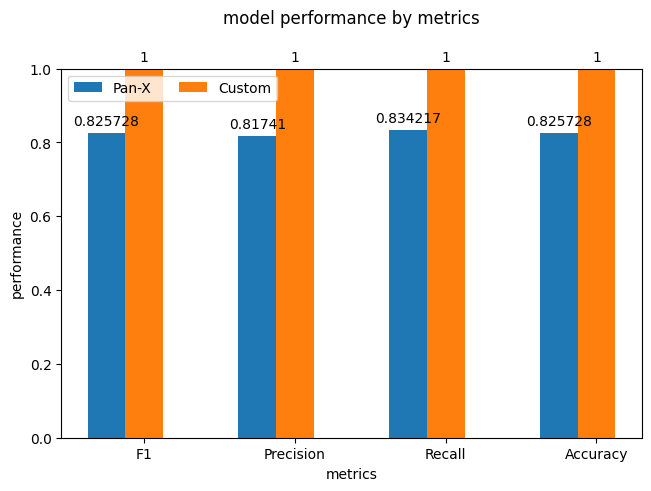

In [75]:
import matplotlib.pyplot as plt
import numpy as np

metrics = ("F1", "Precision",  "Recall", "Accuracy")
model_performance = {
    'Pan-X': (predictions_panx_output.metrics["test_f1"], 
              predictions_panx_output.metrics["test_precision"],
              predictions_panx_output.metrics["test_recall"],
              predictions_panx_output.metrics["test_accuracy"]),
    'Custom': (predictions_custom_output.metrics["test_f1"], 
              predictions_custom_output.metrics["test_precision"],
              predictions_custom_output.metrics["test_recall"],
              predictions_custom_output.metrics["test_accuracy"])
}

x = np.arange(len(metrics))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in model_performance.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('performance')
ax.set_xlabel('metrics')
ax.set_title('model performance by metrics', y=1.1)
ax.set_xticks(x + width, metrics)
ax.legend(loc='upper left', ncols=3)
ax.set_ylim(0, 1)


plt.show()

In [108]:
classification_report_panx = pd.DataFrame(predictions_panx_output.metrics["test_classification_report"]).transpose().drop(['PER'])

In [109]:
classification_report_custom = pd.DataFrame(predictions_custom_output.metrics["test_classification_report"]).transpose()

In [110]:
classification_report_panx.compare(classification_report_custom, result_names=("PAN-X","Custom"))

precision           recall         f1-score         support  \
                 PAN-X Custom     PAN-X Custom     PAN-X Custom    PAN-X   
LOC           0.846516    1.0  0.850333    1.0  0.848420    1.0   4657.0   
ORG           0.784861    1.0  0.747313    1.0  0.765627    1.0   4745.0   
micro avg     0.839477    1.0  0.832139    1.0  0.835792    1.0  13958.0   
macro avg     0.838979    1.0  0.833178    1.0  0.835899    1.0  13958.0   
weighted avg  0.838301    1.0  0.832139    1.0  0.835038    1.0  13958.0   

                     
             Custom  
LOC             1.0  
ORG             2.0  
micro avg       3.0  
macro avg       3.0  
weighted avg    3.0